# TALLER N. 3.
## Punto 1-c:  Entrenamiento de un denoising autoendoder para preentrenar una red profunda.

<p>Integrantes:</p>
<ul>
<li>Juan Camilo Cática</li>
<li>Ricardo Santacruz </li>
<li>Diego Fernando Escobar</li>
</ul>

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print("X_train_full Shape    :", X_train_full.shape)
print("X_train_full[0] Shape :", X_train_full[0].shape)
print("y_train_full Shape    :", y_train_full.shape)
print("X_test Shape          :", X_test.shape)
print("y_test Shape          :", y_test.shape)

X_train_full Shape    : (60000, 28, 28)
X_train_full[0] Shape : (28, 28)
y_train_full Shape    : (60000,)
X_test Shape          : (10000, 28, 28)
y_test Shape          : (10000,)


In [4]:
## obtener los datos de entrenamiento ,validacion
### 5000 para validacion y 55000 para entrenamiento y se normaliza,  maximo valor del pixel = 255

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test  /255.0

In [5]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_valid = X_valid.reshape((len(X_valid), np.prod(X_valid.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


print("X_train.shape :", X_train.shape)
print("X_valid.shape :", X_valid.shape)
print("X_test Shape  :", X_test.shape)

X_train.shape : (55000, 784)
X_valid.shape : (5000, 784)
X_test Shape  : (10000, 784)


## Adicionar Ruido datos de entrada - Gaussian distribution.

In [6]:
noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

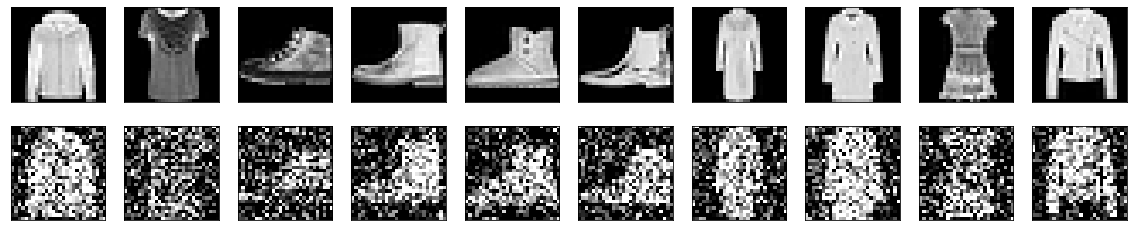

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    
    #Plot real images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    #plot denosing images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
#crea modelo autoencoder 4 capas 
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               1011

In [9]:
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.layers[4].name

'dense_4'

In [11]:
#crear las dos ultimas capas
encoding_dim = 128
encoded_input = Input(shape=(encoding_dim,))
# utima capa
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 101,136
Trainable params: 101,136
Non-trainable params: 0
_________________________________________________________________


In [12]:
#crear las dos medias capas
encoding_dim = 32
encoded_input = Input(shape=(encoding_dim,))
# utima capa
decoder_layer = autoencoder.layers[4]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
Total params: 2,112
Trainable params: 2,112
Non-trainable params: 0
_________________________________________________________________


In [13]:
decoder_layer(encoded_input)

<tf.Tensor 'dense_4_2/Relu:0' shape=(None, 64) dtype=float32>

In [14]:
# Compilar el modelo
#dado que la funcion de activacion de la capa de salida es sigmoide, la funcion de perdida es : binary_crossentropy
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#Entrenar modelo
autoencoder.fit(x_train_noisy, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_valid_noisy, X_valid ))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 15s 275us/step - loss: 0.4094 - val_loss: 0.3436
Epoch 2/50
55000/55000 [==============================] - 10s 180us/step - loss: 0.3328 - val_loss: 0.3220
Epoch 3/50
55000/55000 [==============================] - 9s 159us/step - loss: 0.3212 - val_loss: 0.3160
Epoch 4/50
55000/55000 [==============================] - 11s 192us/step - loss: 0.3165 - val_loss: 0.3147
Epoch 5/50
55000/55000 [==============================] - 9s 162us/step - loss: 0.3136 - val_loss: 0.3105
Epoch 6/50
55000/55000 [==============================] - 11s 192us/step - loss: 0.3110 - val_loss: 0.3079
Epoch 7/50
55000/55000 [==============================] - 10s 182us/step - loss: 0.3087 - val_loss: 0.3063
Epoch 8/50
55000/55000 [==============================] - 12s 216us/step - loss: 0.3072 - val_loss: 0.3048
Epoch 9/50
55000/55000 [==============================] - 14s 260us/step - loss: 0.3057 - val_los

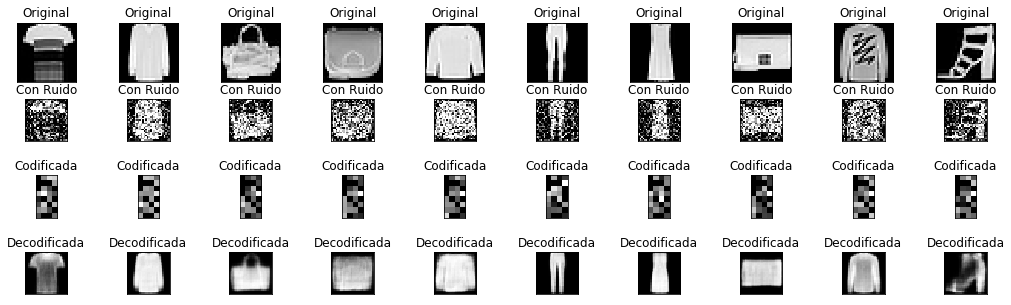

In [15]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

#Imagenes codificadas
encoded_imgs = encoder.predict(x_test_noisy)

#Imagenes decodificadas
decoded_imgs = autoencoder.predict(x_test_noisy)
#decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(18, 5))

for i, image_idx in enumerate(random_test_images):
    
    #plot imagen original
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")
    plt.subplots_adjust(hspace = .8)
    
    # plot  imagen con ruido
    ax = plt.subplot(4, num_images, num_images + i + 1)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Con Ruido")
    plt.subplots_adjust(hspace = .8)
    
    # plot encoded image
    ax = plt.subplot(4, num_images, 2*num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Codificada")
   
    # plot reconstructed image
    ax = plt.subplot(4, num_images, 3*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Decodificada")
plt.show()

# Modelo MLP

In [16]:
#Modelo MLP con capa de entra de  32 variables generadas por el encoder
def crear_modelo(optimizer='adam', init='normal'):
    modelo1 = keras.models.Sequential()
    modelo1.add(keras.layers.Flatten(input_shape=[32,]))
    modelo1.add(keras.layers.Dense(300,kernel_initializer=init,activation ="relu"))
    modelo1.add(keras.layers.Dense(100,kernel_initializer=init, activation ="relu"))
    modelo1.add(keras.layers.Dense(10,kernel_initializer=init,activation ="softmax"))    
    #modelo.summary()
    modelo1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,  metrics=["accuracy"])
    return modelo1

In [17]:
# Clases del conjunto de datos
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
#np.array(class_names)[y_pred]

In [18]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [19]:
#10% dala data entre entrenamiento y test
X = X_train_full[:7000]
y = y_train_full[:7000]
print (X.shape, ". ", y.shape)

(7000, 28, 28) .  (7000,)


In [20]:
#Datos de entrenamiento, validacion  & test

X_test, X_train_ = X[:1000] /255.0 , X[1000:] /255.0
y_test, y_train_ = y[:1000],  y[1000:]

#Entranamineto y Validacion
X_valid, X_train = X_train_[:2000] , X_train_[2000:] 
y_valid, y_train = y_train_[:2000],  y_train_[2000:]


print("X_train.shape  :", X_train.shape)
print("X_valid.shape  :", X_valid.shape)
print("X_test.shape   :", X_test.shape)
print("y_test.shape   :", y_test.shape)
print("y_train.shape  :", y_train.shape)
print("y_valid.shape  :", y_valid.shape)

X_train.shape  : (4000, 28, 28)
X_valid.shape  : (2000, 28, 28)
X_test.shape   : (1000, 28, 28)
y_test.shape   : (1000,)
y_train.shape  : (4000,)
y_valid.shape  : (2000,)


In [21]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_valid = X_valid.reshape((len(X_valid), np.prod(X_valid.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print("X_train.shape :", X_train.shape)
print("X_valid.shape :", X_valid.shape)
print("X_test Shape  :", X_test.shape)

X_train.shape : (4000, 784)
X_valid.shape : (2000, 784)
X_test Shape  : (1000, 784)


In [22]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               1011

In [23]:
autoencoder.layers[:-3]

In [24]:

encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Guardar modelo encoder
encoder.save('encoder.h5')

## Utilizar todas las capas del encoder como capas iniciales del MLP

In [26]:
model_encoder = keras.models.load_model("encoder.h5")
modeloMLP = keras.models.Sequential(model_encoder.layers[:])
modeloMLP.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
# Clone encoder
encoder_clone = keras.models.clone_model(model_encoder)
encoder_clone.set_weights(encoder.get_weights())

In [28]:
model_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [29]:
modeloMLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


### congelar capas iniciales del modelo MLP, las que se reúsan del modelo : model_encoder

In [30]:
for layer in modeloMLP.layers[:3]:
    layer.trainable = False
    print(layer.name)

dense_1
dense_2
dense_3


In [31]:
#col¿miplar moldeo
modeloMLP.compile(loss="sparse_categorical_crossentropy", optimizer='adam',  metrics=["accuracy"])

In [32]:
history = modeloMLP.fit(X_train, y_train, batch_size=32, epochs=50,validation_data=(X_valid, y_valid))

Train on 4000 samples, validate on 2000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 469us/sample - loss: 7.6717 - accuracy: 0.0715 - val_loss: 4.1283 - val_accuracy: 0.1585
Epoch 2/50
4000/4000 [==============================] - 1s 144us/sample - loss: 2.8455 - accuracy: 0.2730 - val_loss: 2.1132 - val_accuracy: 0.3680
Epoch 3/50
4000/4000 [==============================] - 1s 132us/sample - loss: 1.6866 - accuracy: 0.4493 - val_loss: 1.4609 - val_accuracy: 0.5160
Epoch 4/50
4000/4000 [==============================] - 1s 155us/sample - loss: 1.2609 - accuracy: 0.5620 - val_loss: 1.1921 - val_accuracy: 0.5880
Epoch 5/50
4000/4000 [==============================] - 1s 141us/sample - loss: 1.0655 - accuracy: 0.6185 - val_loss: 1.0376 - val_accuracy: 0.6320
Epoch 6/50
4000/4000 [==============================] - 1s 162us/sample - loss: 0.9567 - accuracy: 0.6510 - val_loss: 0.9459 - val_accuracy: 0.6495
Epoch 7/50
4000/4000 [==============================] - 1s 131us

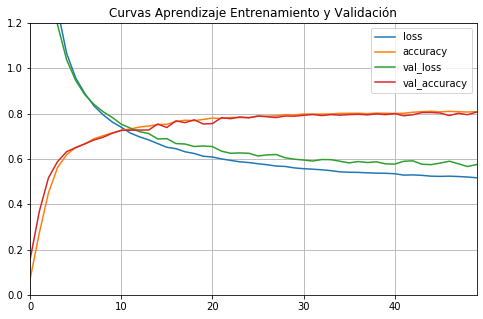

In [33]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1.2) # set the vertical range to [0-1]
plt.title("Curvas Aprendizaje Entrenamiento y Validación")
plt.show()

### Se observa que el accuracy  de entrenamiento y validación   se estabilizan en 81% en la época 20.
### Se observa que el modelo preliminar tiene un buen comportamiento con accuracy %86 sobre el set de datos Test.
### Las curvas de accuracy en entrenamiento y validación son cercanas lo que indica una buena generalización del modelo a pesar de que la accuracy es relativamente baja.
### Las curvas de perdida decrecen constantemente lo que muestra una buena generalización del modelo.

In [34]:
#history1 = modeloMLP.fit(X_train, y_train, batch_size=32, epochs=20,validation_data=(X_valid, y_valid))

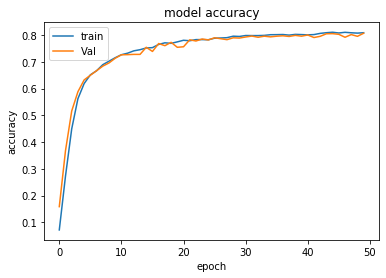

In [35]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

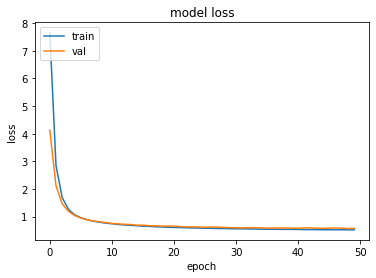

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Ajuste fino de parámetros para verificar si hay  mejor rendimiento del modelo

In [37]:
optomizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#col¿miplar moldeo
modeloMLP.compile(loss="sparse_categorical_crossentropy", optimizer=optomizer,  metrics=["accuracy"])
history1 = modeloMLP.fit(X_train, y_train, batch_size=32, epochs=30,validation_data=(X_valid, y_valid))

Train on 4000 samples, validate on 2000 samples
Epoch 1/30
4000/4000 [==============================] - 1s 342us/sample - loss: 0.5182 - accuracy: 0.8083 - val_loss: 0.5751 - val_accuracy: 0.8010
Epoch 2/30
4000/4000 [==============================] - 1s 139us/sample - loss: 0.5138 - accuracy: 0.8080 - val_loss: 0.5692 - val_accuracy: 0.8045
Epoch 3/30
4000/4000 [==============================] - 1s 128us/sample - loss: 0.5135 - accuracy: 0.8125 - val_loss: 0.5679 - val_accuracy: 0.8015
Epoch 4/30
4000/4000 [==============================] - 1s 149us/sample - loss: 0.5115 - accuracy: 0.8095 - val_loss: 0.5722 - val_accuracy: 0.8035
Epoch 5/30
4000/4000 [==============================] - 1s 129us/sample - loss: 0.5132 - accuracy: 0.8115 - val_loss: 0.5604 - val_accuracy: 0.8010
Epoch 6/30
4000/4000 [==============================] - 1s 144us/sample - loss: 0.5109 - accuracy: 0.8077 - val_loss: 0.5618 - val_accuracy: 0.7990
Epoch 7/30
4000/4000 [==============================] - 1s 133us

## Predicción del modelo MLP

In [38]:
#predict muestra la probabilidad asignada a cad clase a una instnacia dada
X_new = X_test[52:56]
y_proba = modeloMLP.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.94, 0.  , 0.01],
       [0.  , 0.  , 0.92, 0.  , 0.04, 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.02, 0.02, 0.44, 0.1 , 0.14, 0.  , 0.27, 0.  , 0.01, 0.  ],
       [0.84, 0.  , 0.01, 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [39]:
# con predict_classes determian cual es la clase con mayor ptobabilidad para una instacia
y_pred = modeloMLP.predict_classes(X_new)
y_pred

array([7, 2, 2, 0], dtype=int64)

In [40]:
#Comparación  con la clasificacion real
print( y_test[52], ", ", y_test[53], ", " ,y_test[54], ", ", y_test[55])

7 ,  2 ,  2 ,  6


In [41]:
### El modelo se equivoca con la clse 0 y clase 6, de acuardo con la predicción anterior

In [43]:
#Arreglo de imagnes iniciales
val =np.unique(y_train_full)
img_ini = []
y_ini =[]
for i in val:
    indi = np.where(y_train_full == i)[0][0]
    #print(indi)
    y_ini = np.append(y_ini,indi)
    img_ini =np.append(img_ini, X_train_full[indi])

img_ini = np.asarray(img_ini)
y_ini = np.asarray(y_ini)

img_ini =img_ini.reshape(10,28,28)
y_ini =y_ini.reshape(-1)
#print(img_ini.shape)
#print(y_ini)

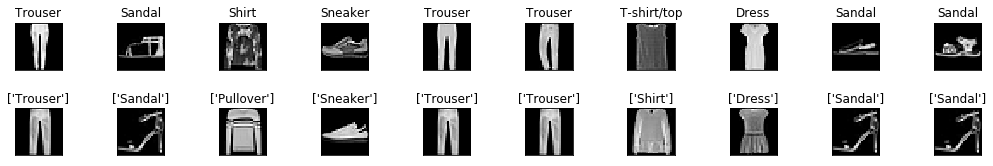

In [44]:
num_images = 10
np.random.seed(42)
X_real = X[:1000]
random_test_images = np.random.randint(X_real.shape[0], size=num_images)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original imagen
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_real[image_idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace = .8)
    clase_real = np.array(class_names)[y_test[image_idx]]
    ax.set_title(clase_real)
    
    # plot Clasificacion imagen
    ax = plt.subplot(3, num_images, num_images + i + 1)
    y_pred = modeloMLP.predict_classes(X_test[image_idx].reshape(1,784))
    plt.imshow(img_ini[y_pred].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    clasificacion = np.array(class_names)[y_pred]
    ax.set_title(clasificacion)

    
plt.show()

## El general el modelo tiene un desempeño con accuracy del 81% , en comparación con el del punto b con 86%, se observa que se equivoca clasificando Shirt como 'T-shirt/top' o 'Pullover', como se ve en las imágenes.

## En términos generales al utilizar y congelar los pesos de un modelo pre entrenado, el tiempo de entrenamiento es más rápido, dado que no necesita calcular los peos de estas capas.

## Con el fin de mejorar el desempeño es necesario probar agregando más capas, y teniendo más datos de entrenamiento y validación.

#early stop
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])